# <font color='blue'>XGBoost</font> eXtreme Gradient Boosting

### https://github.com/dmlc/xgboost

## Пример

Возьмем датасет Boston Housing и обучим XGBoost на нем.

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, mean_squared_error


rng = np.random.RandomState(31337)

boston = load_boston()
y = boston['target']
X = boston['data']

kf = KFold(n_splits=2, shuffle=True, random_state=rng)

XGBoost предлагает 2 способа использования алгоритмов:
* sklearn-совместимые классы XGBClassifier, XGBRegressor

* "оригинальная" python-библиотека

###  sklearn

In [2]:
for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
    xgb_model = xgb.XGBRegressor().fit(X[train_index], y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print("RMSE on fold {}: {}".format(fold_index, np.sqrt(mean_squared_error(actuals, predictions))))

[20:07:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on fold 0: 4.7144853667812905
[20:07:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on fold 1: 3.1474422125618693


### xgboost python

In [4]:
def get_params():
    params = {}
    params["objective"] = "reg:linear"
    params["booster"] = "gbtree"
    params["eval_metric"] = "rmse"
    params["num_boost_round"] = 100
    params["max_depth"] = 3
    params["tree_method"] = "approx"
    params["sketch_eps"] = 1
    
    return params
    
for fold_index, (train_index, test_index) in enumerate(kf.split(X)):

    params = get_params()
    
    xgtrain = xgb.DMatrix(X[train_index], label=y[train_index])
    xgtest = xgb.DMatrix(X[test_index], label=y[test_index])

    bst = xgb.train(params, xgtrain)

    print("RMSE on fold {}: {}".format(fold_index, bst.eval(xgtest)))

[20:16:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on fold 0: [0]	eval-rmse:8.714170
[20:16:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on fold 1: [0]	eval-rmse:7.936395


## Градиентный бустинг на решающих деревьях

<font size=3>

Хотим построить композицию алгоритмов:
<font size=5>

$$ \hat{y_i} = \phi(x_i) = \sum_{k=1}^{K} f_k(x_i) $$

$$ Obj(f) = \sum_{i} l(y_i, \hat{y_i} ) + \sum_k \Omega(f_k)$$

$$ \Omega(f_k) = \gamma T + \frac{1}{2}\lambda\sum_{j=1}^{T}w_j^2 + \alpha\sum_{j=1}^{T}w_j$$


<font size=3>

$ x_i, y_i, \hat{y_i} $ - i-ый объект, правильный ответ и предсказание модели для для него

$ \Omega $ - регуляризация

T - количество листьев в дереве

$ w_j $ - веса, проставленные в листьях дерева

#### Преимущества:


* потенциально очень высокое качество во многих задачах

* находит нелинейные связи

* способен обработать датасеты с большим числом объектов и признаков

#### Недостатки:


* очень много параметров

* модели не интерпретируемы

* по умолчанию не очень быстрый

## Особенности XGBoost

<font size=3>
Написан на C++, есть обертки на Python, R, Java, Scala

С помощью XGBoost выиграна половина конкурсов на Kaggle

Существует коммерческая версия TreeNet

### Регуляризация

<font size=3>
Для уменьшения переобучения целевая функция поддерживает L0, L1, L2 регуляризации

###  Параллелизм (по признакам)

<img src="http://zhanpengfang.github.io/fig_418/feature_speedup.png" height="600" width="600">

<font size=3>
Также есть возможность запускаться на Hadoop, Spark, Flink и DataFlow

### Кастомные функции потерь / метрики качества

В XGBoost встроено множество различных функций потерь:

* reg:linear

* reg:logistic

* binary:logistic

* binary:logitraw

* multi:softmax

* rank:pairwise

* ...

А также соответствующих eval_metric, которые замеряют качество и позволяют сделать early stop.

Но также имеется возможность реализовать свой objective и eval_metric.

Все, что для этого нужно - уметь считать градиент и гессиан.

In [5]:
def my_reg_linear(preds, dtrain):
    labels = dtrain.get_label()
    grad = (preds - labels)
    hess = np.ones(labels.shape[0])
    return grad, hess

In [6]:
for train_index, test_index in kf.split(X):
    params = get_params()
    
    xgtrain = xgb.DMatrix(X[train_index], label=y[train_index])
    xgtest = xgb.DMatrix(X[test_index], label=y[test_index])

    bst = xgb.train(params, xgtrain, obj=my_reg_linear)
    
    predictions = bst.predict(xgtest)
    actuals = y[test_index]

    print(bst.eval(xgtest))

[20:16:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	eval-rmse:7.770299
[20:16:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	eval-rmse:7.848326


### Approximated tree splitting

Если данных слишком много, то можно использовать не все значения признаков, а разделить их на бакеты.

А именно, от каждого признака берутся не все значения, а только некоторое подмножество. Разбиение производится по элементам этого подмножества. 

Для разбиения выбираются взвешенные перцентили.

В оригинальной статье указывается 2 алгоритма:
*   глобальный - один раз выбрать разбиение значений фактора перед началом построения дерева и зафиксировать

    экономим на выборе разбиений, но обычно приходится выбирать больше точек разбиения
    
    
*   локальный - выбирать разбиение после каждого сплита
  
    работает лучше на глубоких деревьях

In [7]:
params["tree_method"] = "approx"
params["sketch_eps"] = 0.2

### Пропуски в данных

XGBoost умеет обрабатывать разреженные матрицы

Но категориальные признаки нужно приводить к числовому виду

Нужно указать, какое число является "пропуском"

При сплите, алгоритм смотрит в какую сторону лучше отвести объекты с пропуском.

In [8]:
xgtrain_missed = xgb.DMatrix(X[test_index], label=y[test_index], missing=-999.0)

### Feature importances

Подсчитывает сколько раз каждый признак использовался для использовался в вершине дерева при разбиении

Это не качество фактора, а его важность

In [9]:
bst.get_fscore()

{'f8': 8,
 'f4': 10,
 'f2': 5,
 'f0': 3,
 'f10': 4,
 'f11': 8,
 'f6': 10,
 'f3': 5,
 'f12': 1,
 'f7': 1}

<Figure size 864x864 with 0 Axes>

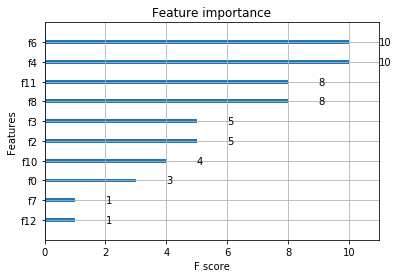

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 12))
xgb.plot_importance(bst)

### Прунинг

Обычно GBM перестает разделять вершины дерева, когда gain становится отрицательным - жадный подход.
Могло оказаться так, что после неудачного сплита с отрицательным gain'ом получится сделать сильно положительный сплит.

XGBoost доводит деревья до max_depth, после чего начинает удалять сплиты, которые несут отрицательный вклад.

### Дообучение модели

In [11]:
dtrain = xgb.DMatrix('agaricus.txt.train')
dtest = xgb.DMatrix('agaricus.txt.test')
watchlist  = [(dtest,'eval'), (dtrain,'train')]
###
# advanced: start from a initial base prediction
#
print ('start running example to start from a initial prediction')
# specify parameters via map, definition are same as c++ version
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
# train xgboost for 1 round
bst = xgb.train( param, dtrain, 1, watchlist )

# Note: we need the margin value instead of transformed prediction in set_base_margin
# do predict with output_margin=True, will always give you margin values before logistic transformation
ptrain = bst.predict(dtrain, output_margin=True)
ptest  = bst.predict(dtest, output_margin=True)

dtrain.set_base_margin(ptrain)
dtest.set_base_margin(ptest)

print ('this is result of running from initial prediction')
bst = xgb.train( param, dtrain, 1, watchlist )

[20:19:53] 6513x127 matrix with 143286 entries loaded from agaricus.txt.train
[20:19:53] 1611x127 matrix with 35442 entries loaded from agaricus.txt.test
start running example to start from a initial prediction
[0]	eval-error:0.042831	train-error:0.046522
this is result of running from initial prediction
[0]	eval-error:0.021726	train-error:0.022263


### Встроенная кросс валидация

In [12]:
xgb.cv(param, dtrain, nfold = 4, num_boost_round=15)

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.022263,0.000940,0.022263,0.002821
1,0.007063,0.000469,0.007063,0.001405
2,0.015200,0.000603,0.015200,0.001809
3,0.007063,0.000469,0.007063,0.001405
4,0.001945,0.001369,0.001996,0.001097
5,0.001228,0.000205,0.001228,0.000614
6,0.001228,0.000205,0.001228,0.000614
7,0.001228,0.000205,0.001228,0.000614
8,0.000870,0.000529,0.001075,0.000798
9,0.000512,0.000512,0.000921,0.000921


### 3 вида бустеров

* gbtree - обычные решающие деревья

* gblinear - линейные модели

* dart - решающие деревья, алгоритм может "выбрасывать" некоторые из деревьев, уменьшая переобучение


### Веса для объектов

Мы можем учитывать каждый объект со своим весом, этот вес будет учитываться и при выборе бакетов при приближенном построении деревьев, при сплите, при подсчете Objective.

Допустим, мы хотим классифицировать короткие сообщения.  Некоторые из них повторяются. В этом случае выгодно "слить" вместе все дубликаты и посчитать их один раз, но с большим весом. При неизменном качестве это уменьшит время обучения 

In [13]:
repeats = np.random.randint(low=1, high=5, size=X.shape[0])
train_examples = 300


X_train = X[:train_examples]
X_test = X[train_examples:]
y_train = y[:train_examples]
y_test = y[train_examples:]


X_train_repeated = np.repeat(X_train, repeats[:train_examples], axis=0)
X_test_repeated = np.repeat(X_test, repeats[train_examples:], axis=0)
y_train_repeated = np.repeat(y_train, repeats[:train_examples], axis=0)


xgtrain_repeated = xgb.DMatrix(X_train_repeated, label=y_train_repeated)
xgtrain_weighted = xgb.DMatrix(X_train, label=y_train, weight=repeats[:train_examples])

xgtest = xgb.DMatrix(X_test, label=y_test)

bst = xgb.train(params, xgtrain_repeated)
print("Repeated dataset. Train size: {}, error: {}".format(xgtrain_repeated.num_row(), bst.eval(xgtest)))

bst = xgb.train(params, xgtrain_weighted)
print("Weighted dataset. Train size: {}, error: {}".format(xgtrain_weighted.num_row(), bst.eval(xgtest)))


[20:24:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Repeated dataset. Train size: 739, error: [0]	eval-rmse:6.486039
[20:24:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Weighted dataset. Train size: 300, error: [0]	eval-rmse:6.486039


# Другие параметры

### Бустинг

<i> learning_rates </i> - можно настроить убывающую скорость

### Параметры деревьев

<font size=3>
<i> max_depth </i> - максимальная глубина дерева. Слишком большая глубина ведет к переобучению

<i> subsample, colsample_bytree, colsample_bylevel </i> - сэмплирование по объектам и признакам


<i> min_child_weight </i> - минимальная сумма весов в листе

<i> scale_pos_weight </i> - вес целого класса, используется если один класс заметно чаще встречается, чем другой


### Дополнительные параметры для DART

<font size=3>
<i> sample_type </i> - стратегия выбора деревьев для выкидывания

<i> rate_drop </i> - какую долю выкидываем

<i> skip_drop </i> - шанс пропустить дроп на этой итерации

# Настраиваем XGBoost 

<font size=3>
* Выбираем относительно большую learning_rate ($ \eta \in [0.05, 0.3]$), подбираем оптимальное число деревьев для выбранного $ \eta $

* Настраиваем параметры деревьев, начиная с самых значимых (max_depth, min_child_weight, gamma, subsample, colsample_bytree)

* Настраиваем регуляризации ($ \lambda, \alpha $)

* Уменьшаем learning_rate, пропорционально увеличиваем число деревьев